## 1. Import libraries

In [1]:
import requests 
import pandas as pd 
import numpy as np 
import random 
import requests
import geocoder
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from pandas.io.json import json_normalize
import folium 
from sklearn.cluster import KMeans

## 2. Loading neighborhoods in Warsaw

In [2]:
neigh = pd.read_html('https://pl.wikipedia.org/wiki/Podzia%C5%82_administracyjny_Warszawy')[0]

In [3]:
neigh.head()

,Dzielnica,Liczba mieszkańców(1.01.2019)[1],Gęstość zaludnienia[osób/km²](1.01.2019)[1],Powierzchnia[km²][1]
0,Mokotów,217 683,6146,3542
1,Praga-Południe,179 836,8036,2238
2,Ursynów,150 668,3441,4379
3,Wola,140 958,7319,1926
4,Bielany,131 910,4079,3234


In [4]:
address = 'Warsaw, Poland'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Warsaw, Poland are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of Warsaw, Poland are 52.2337172, 21.07141112883227.


In [5]:
def get_latlng(neighs):
    lat_lng_coords = []
    for neigh in neighs:
        g = geocoder.arcgis('{}, Warsaw, Poland'.format(neigh))
        lat_lng_coords.append(g.latlng)
    return lat_lng_coords

lat_lng_coords = get_latlng(neigh['Dzielnica'])

In [6]:
lat_lng_arr = np.array(lat_lng_coords)
neigh['Latitude']=lat_lng_arr[:,0]
neigh['Longitude']=lat_lng_arr[:,1]
neigh.columns = ['Neighborhood','Population','Density km²','Area in km²','Latitude','Longitude']
neigh = neigh[:-1]
neigh

,Neighborhood,Population,Density km²,Area in km²,Latitude,Longitude
0,Mokotów,217 683,6146,3542,52.19539,21.00850
1,Praga-Południe,179 836,8036,2238,52.23633,21.09840
2,Ursynów,150 668,3441,4379,52.15418,21.03786
3,Wola,140 958,7319,1926,52.23903,20.97123
4,Bielany,131 910,4079,3234,52.27697,20.94778
5,Targówek,124 279,5131,2422,52.27726,21.06594
6,Bemowo,123 932,4967,2495,52.25269,20.91244
7,Śródmieście,115 395,7411,1557,52.23560,21.01037
8,Białołęka,124 125,1699,7304,52.31097,20.99324
9,Ochota,82 774,8516,972,52.21314,20.97069


## 3.Map of Warsaw

In [7]:
warsaw_map = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# add markers to map
for lat, lng, nei in zip(neigh['Latitude'], neigh['Longitude'], neigh['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(warsaw_map)  
    
warsaw_map

## 4. Import data from Foursquare

In [17]:
CLIENT_ID = 'FUDKOXBJ3EFRUF3IHSWJDHAD035APOLUWYOK35DXF5ACYJ4K' 
CLIENT_SECRET = 'HKKU5VQB2PUSZRHMXIKWMW0HAF5LHMLWJPXAGRTYYOYAB0OA' 
VERSION = '20200422' 

venues = []

for lat, lng, name in zip(neigh['Latitude'], neigh['Longitude'], neigh['Neighborhood']):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        700, 
        50)
            
    results = requests.get(url).json()["response"]['groups'][0]['items']
            
    for venue in results:
        venues.append((
            name,
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))
    
venues_df = pd.DataFrame(venues)
venues_df.shape

(397, 7)

In [18]:
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'Name', 'Latitude', 'Longitude', 'Category']

In [19]:
venues_df

,Neighborhood,Latitude,Longitude,Name,Latitude,Longitude,Category
0,Mokotów,52.19539,21.00850,Bezownia,52.192392,21.010170,Dessert Shop
1,Mokotów,52.19539,21.00850,Efes Kebab,52.196242,21.013851,Kebab Restaurant
2,Mokotów,52.19539,21.00850,Tam i z powrotem,52.195179,21.004044,Café
3,Mokotów,52.19539,21.00850,II Ogród Jordanowski,52.196446,21.014244,Playground
4,Mokotów,52.19539,21.00850,Locale,52.192363,21.003873,Italian Restaurant
...,...,...,...,...,...,...,...
392,Wesoła,52.22292,21.23074,Lidl,52.222397,21.223320,Market
393,Wesoła,52.22292,21.23074,Biedronka,52.219101,21.223548,Supermarket
394,Wesoła,52.22292,21.23074,Pizzeria Biesiadowo,52.218035,21.234650,Pizza Place
395,Wesoła,52.22292,21.23074,Pizzeria Pe-Pe,52.216723,21.230978,Pizza Place


## 5. Group venues by category

In [20]:
kl_onehot = pd.get_dummies(venues_df[['Category']], prefix="", prefix_sep="")

kl_onehot['Neighborhood'] = venues_df['Neighborhood'] 

fixed_columns = [kl_onehot.columns[-1]] + list(kl_onehot.columns[:-1])
kl_onehot = kl_onehot[fixed_columns]

kl_grouped = kl_onehot.groupby(["Neighborhood"]).sum().reset_index()

kl_grouped

,Neighborhood,Zoo Exhibit,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bar,Basketball Court,...,Theater,Theme Park,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Zoo
0,Bemowo,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,Białołęka,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Bielany,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ochota,0,0,0,0,1,0,0,0,1,...,1,1,0,1,1,0,1,0,0,0
5,Praga-Południe,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Praga-Północ,5,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
7,Targówek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Ursus,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
9,Ursynów,0,0,0,0,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0


## 6. Find most common venues in neighborhoods

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Neighborhood'] = kl_grouped['Neighborhood']

for ind in np.arange(kl_grouped.shape[0]):
    top_venues.iloc[ind, 1:] = return_most_common_venues(kl_grouped.iloc[ind, :], num_top_venues)

top_venues

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bemowo,Grocery Store,Pizza Place,Burger Joint,Middle Eastern Restaurant,Supermarket,Flea Market,Dessert Shop,Playground,Italian Restaurant,Pharmacy
1,Białołęka,Bus Station,Business Service,Train Station,Tennis Court,Zoo,Donut Shop,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Discount Store
2,Bielany,Café,Bus Stop,Park,Bookstore,Paper / Office Supplies Store,Asian Restaurant,Tram Station,Ice Cream Shop,Indian Restaurant,Beer Bar
3,Mokotów,Café,Grocery Store,Italian Restaurant,Modern European Restaurant,Cupcake Shop,Burger Joint,Indian Restaurant,Kebab Restaurant,Farmers Market,Eastern European Restaurant
4,Ochota,Pharmacy,Pizza Place,Italian Restaurant,Hotel,Ice Cream Shop,Burger Joint,Pub,Electronics Store,Bus Station,General Entertainment
5,Praga-Południe,Supermarket,Hotel,Electronics Store,Park,Fast Food Restaurant,Farmers Market,Multiplex,Cosmetics Shop,Coffee Shop,Pharmacy
6,Praga-Północ,Zoo Exhibit,Fast Food Restaurant,Café,Music Venue,Diner,Plaza,Coffee Shop,Convenience Store,Bus Station,Bus Stop
7,Targówek,Bus Station,Market,Liquor Store,Pizza Place,Clothing Store,River,Donut Shop,Dumpling Restaurant,Drugstore,Diner
8,Ursus,Sporting Goods Shop,Park,Clothing Store,Lingerie Store,Supermarket,Chocolate Shop,Pizza Place,Ice Cream Shop,Food & Drink Shop,Hotel
9,Ursynów,Café,Pizza Place,Gym / Fitness Center,Supermarket,Sushi Restaurant,Burger Joint,Discount Store,Bus Line,Coffee Shop,Modern European Restaurant


## 7. School data

In [13]:
schools=pd.read_html('http://egzaminy.edu.pl/rekrutacja-do-liceum/rankingi-szkol-warszawskich/ranking-gimnazjow-publicznych-i-niepublicznych-w-warszawie-z-najlepszymi-wynikami-na-egzaminach-2016-r-portalu-egzaminy-edu-pl/')[0]
schools.drop(['L.P', 'Nazwa szkołyPatronAdres','Rok'], axis=1,inplace=True)
schools.columns=['Neighborhood','School Score']
schools['Neighborhood']=schools['Neighborhood'].replace({'Praga Północ': 'Praga-Północ', 'Praga Południe': 'Praga-Południe'})
schools = schools.groupby(['Neighborhood']).max().sort_values(by='School Score',ascending=False)
schools

,School Score
Neighborhood,
Mokotów,94.90
Praga-Północ,92.72
Śródmieście,92.02
Bielany,89.97
Żoliborz,85.57
Praga-Południe,85.37
Wola,84.33
Ochota,83.22
Ursynów,78.06


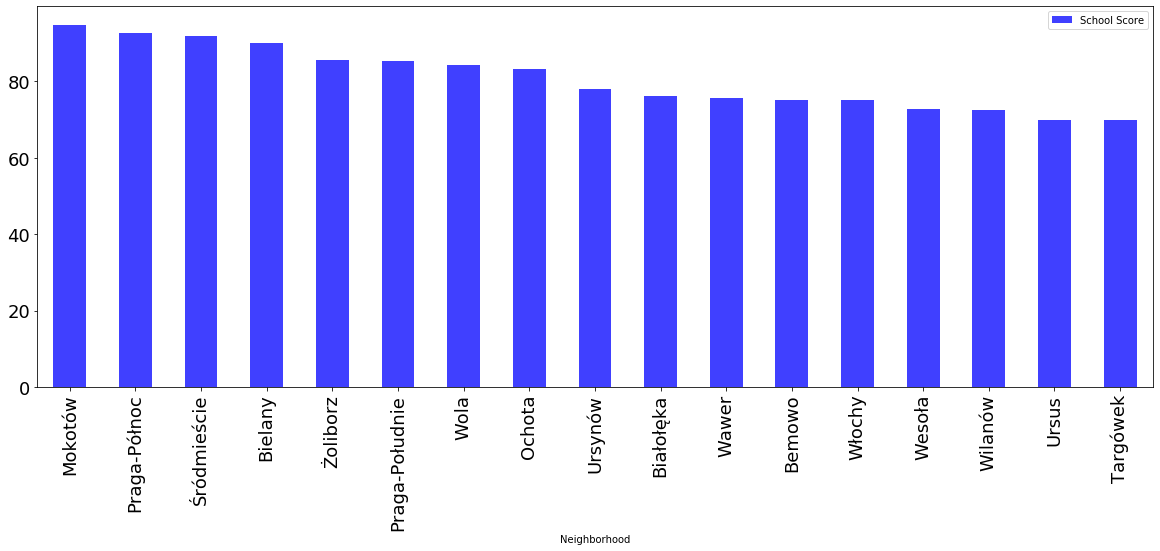

In [15]:
schools.plot(kind='bar',figsize=(20,7),color='blue',alpha=0.75,fontsize=18);

## 8. Price per square meter

In [9]:
prices = open("prices.txt", "r")
house_prices = []
for line in prices:
    elements=line.split(' ')
    house_prices.append([elements[0],elements[1]])
    
hp_df = pd.DataFrame(house_prices, columns =['Neighborhood', 'Price per m^2'])

hp_df.Neighborhood=['Śródmieście',
 'Żoliborz',
 'Wola',
 'Mokotów',
 'Ochota',
 'Wilanów',
 'Praga-Północ',
 'Bielany',
 'Ursynów',
 'Praga-Południe',
 'Włochy',
 'Bemowo',
 'Targówek',
 'Ursus',
 'Białołęka',
 'Wesoła',
 'Wawer',
 'Rembertów']
hp_df["Price per m^2"]=hp_df["Price per m^2"].astype(float)
hp_df=hp_df.set_index('Neighborhood')

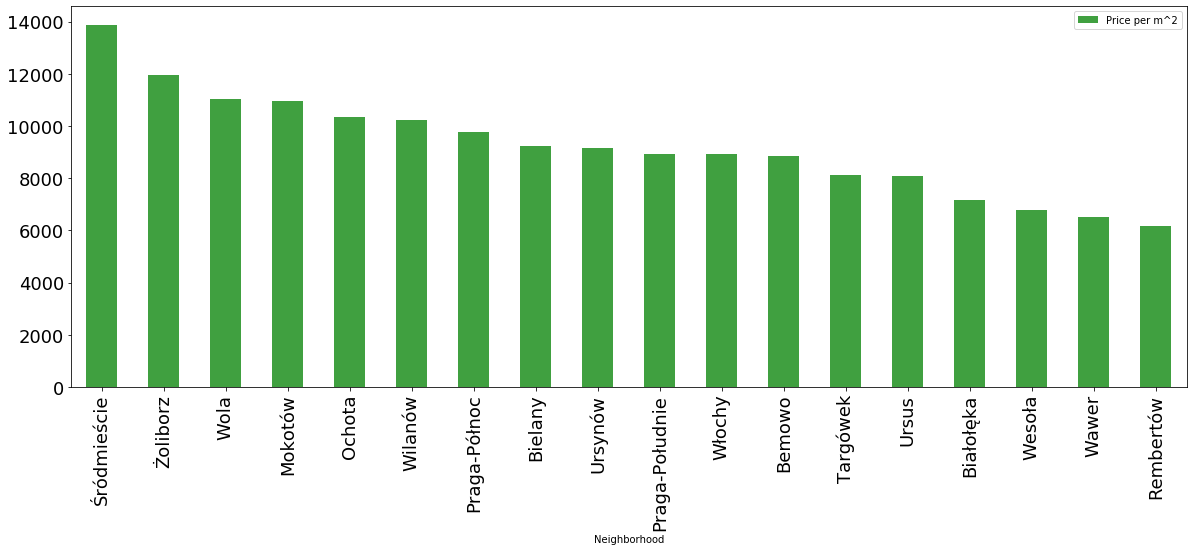

In [11]:
hp_df.plot(kind='bar',figsize=(20,7),color='green',alpha=0.75,fontsize=18);

In [18]:
schools = schools.join(hp_df, on='Neighborhood')

In [19]:
merge_df=pd.merge(schools, kl_grouped, on='Neighborhood')

In [20]:
merge_df=merge_df.drop('Neighborhood', 1)

In [21]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(merge_df)
kmeans.labels_

array([2, 4, 1, 0, 2, 0, 2, 4, 0, 3, 3, 0, 0, 3, 4, 5, 5])

In [22]:
neigh["Cluster Labels"] = kmeans.labels_+1
neigh = neigh.join(schools, on='Neighborhood')
neigh = neigh.join(top_venues.set_index('Neighborhood'), on='Neighborhood')
neigh

,Neighborhood,Population,Area in km²,Density per km²,Latitude,Longitude,Cluster Labels,School Score,Price per m^2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mokotów,217 683,6146,3542,52.19539,21.00850,3,94.90,10966.0,Café,Farmers Market,Modern European Restaurant,Italian Restaurant,Bistro,Eastern European Restaurant,Liquor Store,Bus Station,Cupcake Shop,Burger Joint
1,Praga-Południe,179 836,8036,2238,52.23633,21.09840,5,85.37,8936.0,Electronics Store,Hotel,Fast Food Restaurant,Coffee Shop,Park,Bookstore,Farmers Market,Diner,Cosmetics Shop,Multiplex
2,Ursynów,150 668,3441,4379,52.15418,21.03786,2,78.06,9148.0,Café,Pizza Place,Burger Joint,Gym / Fitness Center,Supermarket,Park,Italian Restaurant,Pool,Juice Bar,Chinese Restaurant
3,Wola,140 958,7319,1926,52.23903,20.97123,1,84.33,11024.0,Grocery Store,Pizza Place,Chinese Restaurant,Café,Italian Restaurant,Department Store,Donut Shop,Plaza,Pub,Eastern European Restaurant
4,Bielany,131 910,4079,3234,52.27697,20.94778,3,89.97,9225.0,Café,Park,Bookstore,Bus Stop,Grocery Store,Tram Station,Ice Cream Shop,Bakery,Indian Restaurant,Metro Station
5,Targówek,124 279,5131,2422,52.27726,21.06594,1,69.88,8114.0,Bus Station,Market,Pizza Place,Liquor Store,Clothing Store,Zoo,Donut Shop,Dumpling Restaurant,Drugstore,Diner
6,Bemowo,123 932,4967,2495,52.25269,20.91244,3,75.20,8842.0,Italian Restaurant,Indian Restaurant,Plaza,Supermarket,Playground,Flea Market,Burger Joint,Pizza Place,Pharmacy,Dessert Shop
7,Śródmieście,115 395,7411,1557,52.23560,21.01037,5,92.02,13888.0,Café,Hotel,Bookstore,Greek Restaurant,Coffee Shop,Dessert Shop,Hostel,Creperie,Park,Chocolate Shop
8,Białołęka,124 125,1699,7304,52.31097,20.99324,1,76.16,7180.0,Bus Station,Business Service,Tennis Court,Train Station,Zoo,Discount Store,Dumpling Restaurant,Drugstore,Donut Shop,Diner
9,Ochota,82 774,8516,972,52.21314,20.97069,4,83.22,10357.0,Electronics Store,Hotel,Italian Restaurant,Business Service,Department Store,Burger Joint,Pizza Place,Pharmacy,Park,Bus Station


## 8. Create map of clusters

In [23]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

kclusters = 7


x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []



for lat, lon, poi, cluster in zip(neigh['Latitude'],
                                  neigh['Longitude'],
                                  neigh['Neighborhood'],
                                  neigh['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 9.Cluster analysis

In [25]:
neigh.loc[neigh['Cluster Labels'] == 1, 
                     'School Score':"10th Most Common Venue"].head()

,School Score,Price per m^2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,84.33,11024.0,Grocery Store,Pizza Place,Chinese Restaurant,Café,Italian Restaurant,Department Store,Donut Shop,Plaza,Pub,Eastern European Restaurant
5,69.88,8114.0,Bus Station,Market,Pizza Place,Liquor Store,Clothing Store,Zoo,Donut Shop,Dumpling Restaurant,Drugstore,Diner
8,76.16,7180.0,Bus Station,Business Service,Tennis Court,Train Station,Zoo,Discount Store,Dumpling Restaurant,Drugstore,Donut Shop,Diner
11,92.72,9769.0,Zoo Exhibit,Fast Food Restaurant,Bus Station,Café,Plaza,Music Venue,Convenience Store,Coffee Shop,Diner,Chinese Restaurant
12,69.97,8088.0,Park,Ice Cream Shop,Sporting Goods Shop,Fast Food Restaurant,Supermarket,Chocolate Shop,Clothing Store,Pizza Place,Train Station,Hotel


In [26]:
neigh.loc[neigh['Cluster Labels'] == 2, 
                     'School Score':"10th Most Common Venue"].head()

,School Score,Price per m^2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,78.06,9148.0,Café,Pizza Place,Burger Joint,Gym / Fitness Center,Supermarket,Park,Italian Restaurant,Pool,Juice Bar,Chinese Restaurant


In [27]:
neigh.loc[neigh['Cluster Labels'] == 3, 
                     'School Score':"10th Most Common Venue"].head()

,School Score,Price per m^2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94.90,10966.0,Café,Farmers Market,Modern European Restaurant,Italian Restaurant,Bistro,Eastern European Restaurant,Liquor Store,Bus Station,Cupcake Shop,Burger Joint
4,89.97,9225.0,Café,Park,Bookstore,Bus Stop,Grocery Store,Tram Station,Ice Cream Shop,Bakery,Indian Restaurant,Metro Station
6,75.20,8842.0,Italian Restaurant,Indian Restaurant,Plaza,Supermarket,Playground,Flea Market,Burger Joint,Pizza Place,Pharmacy,Dessert Shop


In [28]:
neigh.loc[neigh['Cluster Labels'] == 4, 
                     'School Score':"10th Most Common Venue"].head()

,School Score,Price per m^2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,83.22,10357.0,Electronics Store,Hotel,Italian Restaurant,Business Service,Department Store,Burger Joint,Pizza Place,Pharmacy,Park,Bus Station
10,75.71,6500.0,Bus Line,Pool,Bus Station,Gym,Café,Train Station,Flower Shop,Middle Eastern Restaurant,Drugstore,Donut Shop
13,85.57,11969.0,Park,Café,Italian Restaurant,Diner,Grocery Store,Coffee Shop,Plaza,Beer Bar,Gym / Fitness Center,Food & Drink Shop


In [29]:
neigh.loc[neigh['Cluster Labels'] == 5, 
                     'School Score':"10th Most Common Venue"].head()

,School Score,Price per m^2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,85.37,8936.0,Electronics Store,Hotel,Fast Food Restaurant,Coffee Shop,Park,Bookstore,Farmers Market,Diner,Cosmetics Shop,Multiplex
7,92.02,13888.0,Café,Hotel,Bookstore,Greek Restaurant,Coffee Shop,Dessert Shop,Hostel,Creperie,Park,Chocolate Shop
14,75.15,8910.0,Hotel,Supermarket,Tram Station,Grocery Store,Bed & Breakfast,Coffee Shop,Noodle House,Department Store,Café,Eastern European Restaurant


In [30]:
neigh.loc[neigh['Cluster Labels'] == 6, 
                     'School Score':"10th Most Common Venue"].head()

,School Score,Price per m^2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,72.55,10229.0,Italian Restaurant,Gym,Café,Fast Food Restaurant,Steakhouse,Polish Restaurant,Pool,Public Art,Bus Station,Chinese Restaurant
16,72.78,6785.0,Market,Grocery Store,Pizza Place,Supermarket,Italian Restaurant,Café,Discount Store,Dumpling Restaurant,Drugstore,Donut Shop


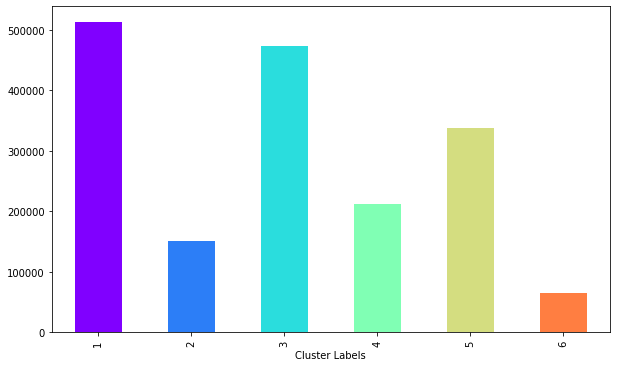

In [31]:
neigh.Population = neigh.Population.astype(str).str.replace(' ', '')
neigh['Population'] = pd.to_numeric(neigh['Population'])
PpC = neigh.groupby("Cluster Labels").Population.sum()
PpC.plot(kind="bar", figsize=(10,6), color = rainbow)